In [156]:
import pandas as pd
import numpy as np
import os, sys, joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# GLOBALS
LOCAL_ROOT = '/Users/varunn/Documents/ExternalTest/'
PROJ_PATH = os.path.join(LOCAL_ROOT, 'LendEast')
BANK_FULL_FN = os.path.join(PROJ_PATH, 'bank-full.csv')
BANK_FN = os.path.join(PROJ_PATH, 'bank.csv')

In [8]:
# read data
bank_full_df = pd.read_csv(BANK_FULL_FN, sep=';')
bank_df = pd.read_csv(BANK_FN, sep=';')

In [12]:
print(bank_full_df.shape)
print(bank_full_df.head())
print(bank_full_df.dtypes)

(45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
age           int64
job          object
marital      object
education    object
default      object

In [11]:
bank_full_df.drop_duplicates(inplace=True)
bank_full_df.reset_index(drop=True, inplace=True)

In [31]:
bank_full_df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
concat       0
dtype: int64

In [50]:
bank_full_df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [51]:
bank_full_df['y'] = bank_full_df['y'].apply(
    lambda x: 1 if x=='yes' else 0)
bank_df['y'] = bank_df['y'].apply(lambda x: 1 if x=='yes' else 0)

In [53]:
print(bank_full_df['y'].value_counts())
print(100.*bank_full_df['y'].mean())
print(100.*bank_df['y'].mean())

0    39922
1     5289
Name: y, dtype: int64
11.698480458295547
11.523999115239992


#### Check if bank_df is a subset of bank_full_df and if so, use bank_df as test set

In [46]:
bank_full_df['concat'] = pd.Series(bank_full_df.values.tolist()).map(
    lambda x: '_'.join(map(str,x)))
bank_df['concat'] = pd.Series(bank_df.values.tolist()).map(
    lambda x: '_'.join(map(str,x)))

In [47]:
print(bank_full_df['concat'].nunique())
print(bank_df['concat'].nunique())

assert bank_df.shape[0] == bank_df['concat'].nunique()
assert bank_full_df.shape[0] == bank_full_df['concat'].nunique()

45211
4521


In [49]:
def _issubset(data_big, data_small, col='concat'):
    small_values = data_small[col].unique().tolist()
    big_values = data_big[col].unique().tolist()
    diff_values = set(small_values) - set(big_values)
    #print(len(diff_values))
    if diff_values:
        return False
    else:
        return True
    
print(_issubset(bank_full_df, bank_df))

True


In [55]:
# sampling
test_ids = bank_df['concat'].unique().tolist()
bank_full_df['sample'] = 'dev'
mask = bank_full_df['concat'].isin(test_ids)
bank_full_df.loc[mask, 'sample'] = 'val'

print(bank_full_df['sample'].value_counts())
table = pd.crosstab(bank_full_df['sample'], bank_full_df['y'])
table['total'] = table.sum(axis=1)
table.loc['total', :] = table.sum(axis=0)
table['DV'] = list(map(lambda x,y: 1.*x/y, table[1], table['total']))
print(table)

dev    40690
val     4521
Name: sample, dtype: int64
y             0       1    total        DV
sample                                    
dev     35922.0  4768.0  40690.0  0.117179
val      4000.0   521.0   4521.0  0.115240
total   39922.0  5289.0  45211.0  0.116985


In [64]:
# utility functions
def calc_crosstab(data, x_col, y_col):
    table = pd.crosstab(data[x_col], data[y_col])
    table['total'] = table.sum(axis=1)
    table.loc['total', :] = table.sum(axis=0)
    table['DV'] = list(map(lambda x,y: 1.*x/y, table[1], table['total']))
    return table

### Exploration

In [57]:
mask = bank_full_df['sample'] == 'dev'

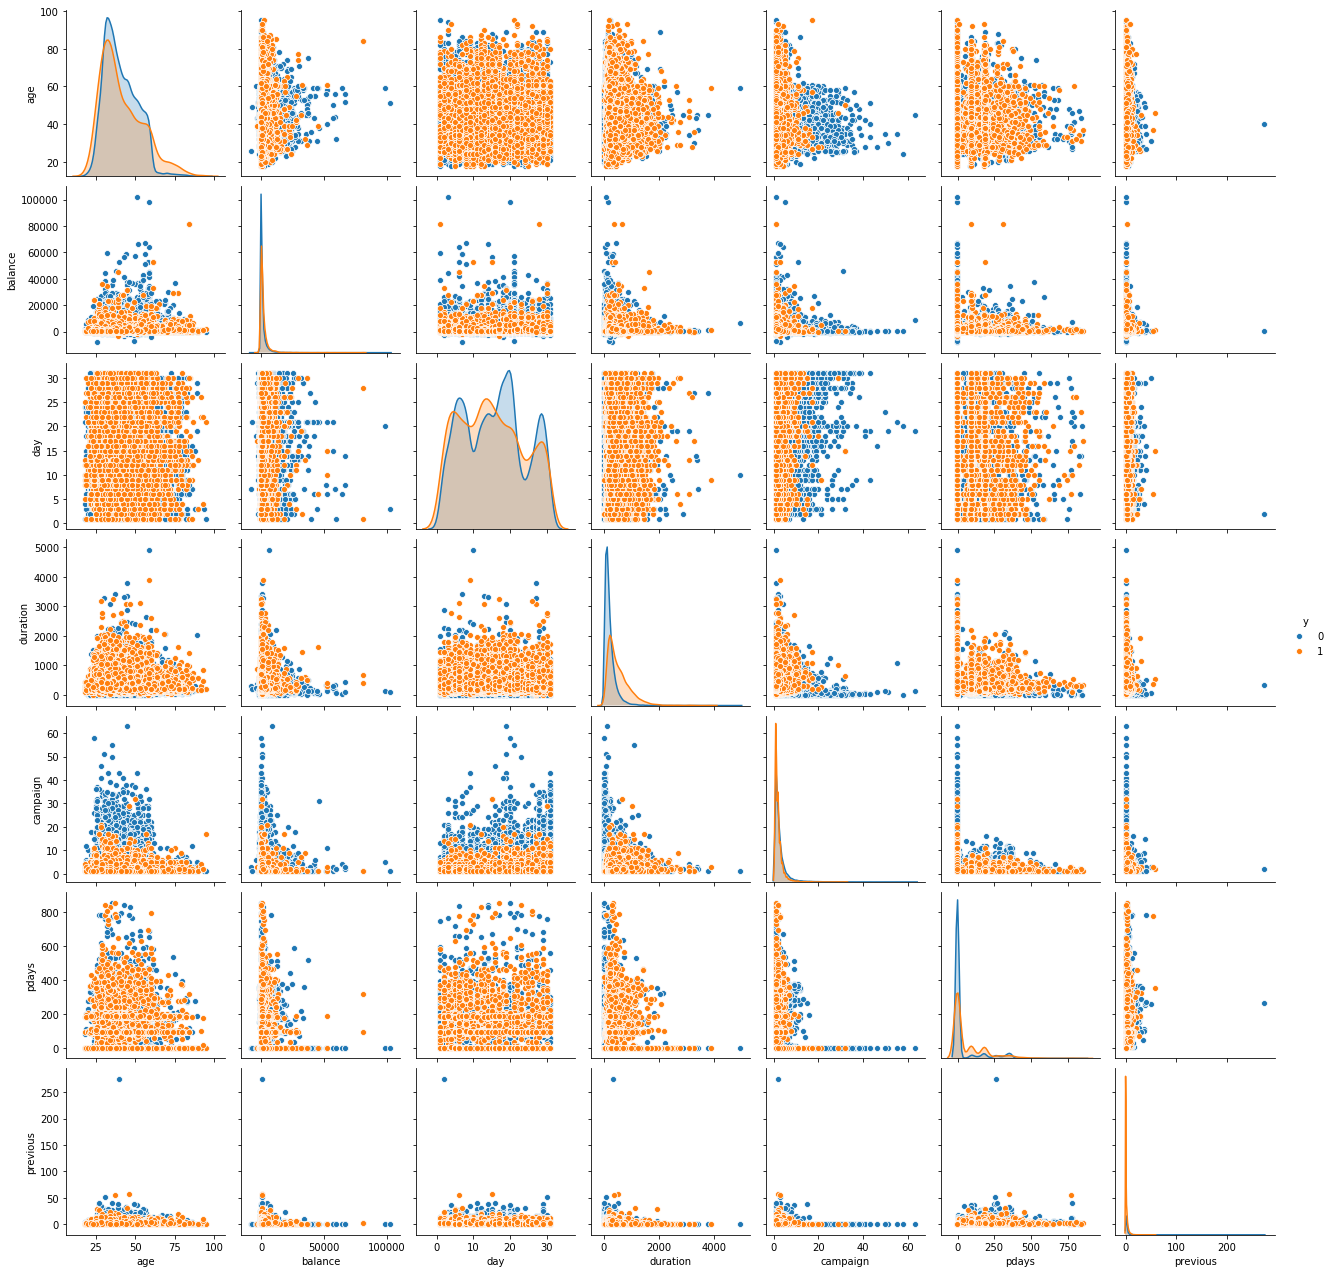

In [253]:
sns.pairplot(bank_full_df.loc[mask, :], hue='y', hue_order=[0, 1])

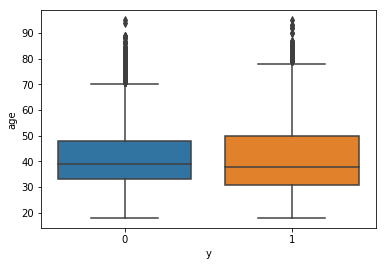

In [63]:
# age
sns.boxplot(x='y', y='age', data=bank_full_df.loc[mask, :])

     count         mean          std     min    25%    50%      75%       max
y                                                                            
0  35922.0  1292.635766  2962.555417 -8019.0   58.0  417.0  1342.00  102127.0
1   4768.0  1829.652685  3597.095353 -3058.0  215.0  734.0  2156.75   81204.0




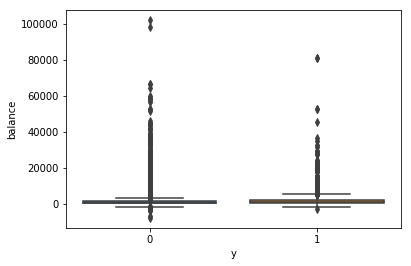

In [74]:
# balance
sns.boxplot(x='y', y='balance', data=bank_full_df.loc[mask, :],)
print(bank_full_df.loc[mask, :].groupby('y')['balance'].describe())
print('\n')

     count        mean         std  min    25%    50%    75%     max
y                                                                   
0  35922.0  220.607706  207.049358  0.0   95.0  163.5  278.0  4918.0
1   4768.0  535.606544  392.768755  8.0  242.0  423.5  720.0  3881.0




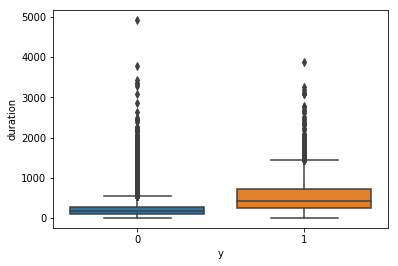

In [76]:
# duration
sns.boxplot(x='y', y='duration', data=bank_full_df.loc[mask, :],)
print(bank_full_df.loc[mask, :].groupby('y')['duration'].describe())
print('\n')

     count      mean       std  min  25%  50%  75%   max
y                                                       
0  35922.0  2.844580  3.212825  1.0  1.0  2.0  3.0  63.0
1   4768.0  2.127307  1.902033  1.0  1.0  2.0  2.0  32.0




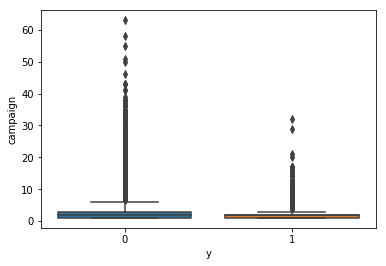

In [77]:
# campaign
sns.boxplot(x='y', y='campaign', data=bank_full_df.loc[mask, :],)
print(bank_full_df.loc[mask, :].groupby('y')['campaign'].describe())
print('\n')

     count       mean         std  min  25%  50%   75%    max
y                                                            
0  35922.0  36.467624   96.809388 -1.0 -1.0 -1.0  -1.0  850.0
1   4768.0  68.709941  118.487117 -1.0 -1.0 -1.0  98.0  854.0




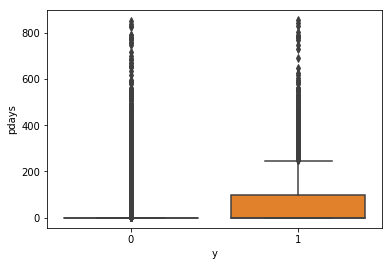

In [78]:
# pdays
sns.boxplot(x='y', y='pdays', data=bank_full_df.loc[mask, :],)
print(bank_full_df.loc[mask, :].groupby('y')['pdays'].describe())
print('\n')

     count      mean      std  min  25%  50%  75%    max
y                                                       
0  35922.0  0.505595  2.31629  0.0  0.0  0.0  0.0  275.0
1   4768.0  1.179111  2.60194  0.0  0.0  0.0  1.0   58.0




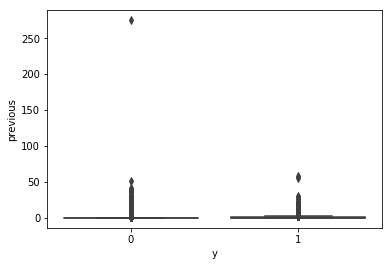

In [81]:
# previous
sns.boxplot(x='y', y='previous', data=bank_full_df.loc[mask, :],)
print(bank_full_df.loc[mask, :].groupby('y')['previous'].describe())
print('\n')

In [80]:
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'day', 'month', 'poutcome']:
    print(col)
    print(calc_crosstab(bank_full_df.loc[mask, :], col, 'y'))
    print('\n')

job
y                    0       1    total        DV
job                                              
admin.          4120.0   573.0   4693.0  0.122097
blue-collar     8147.0   639.0   8786.0  0.072729
entrepreneur    1211.0   108.0   1319.0  0.081880
housemaid       1033.0    95.0   1128.0  0.084220
management      7319.0  1170.0   8489.0  0.137825
retired         1572.0   462.0   2034.0  0.227139
self-employed   1229.0   167.0   1396.0  0.119628
services        3406.0   331.0   3737.0  0.088574
student          604.0   250.0    854.0  0.292740
technician      6072.0   757.0   6829.0  0.110851
unemployed       986.0   189.0   1175.0  0.160851
unknown          223.0    27.0    250.0  0.108000
total          35922.0  4768.0  40690.0  0.117179


marital
y               0       1    total        DV
marital                                     
divorced   4134.0   545.0   4679.0  0.116478
married   21939.0  2478.0  24417.0  0.101487
single     9849.0  1745.0  11594.0  0.150509
total     3

### Feature Creation and Engineering

In [87]:
df = bank_full_df.copy()

In [92]:
# GLOBAL VARIABLE NAMES
DV = 'y'
ID = 'concat'
SAMPLE = 'sample'
DISCRETE_FEATS = ['job', 'marital', 'education', 'default', 'housing',
                  'loan', 'contact', 'day', 'month', 'poutcome']
NUMERIC_FEATS = ['age', 'balance', 'duration', 'campaign', 'pdays',
                 'previous']
FEATS = DISCRETE_FEATS + NUMERIC_FEATS
FEAT_PREFIX = 'LE'

In [93]:
print(len(FEATS), '\t', len(DISCRETE_FEATS), '\t', len(NUMERIC_FEATS))

16 	 10 	 6


In [86]:
# function to group values of discrete variables to account for low frequencies
from math import log


def group_cats_with_lower_freq(data, cat_col, freq_thresh=20):
    """
    groups values which are of lower frequencies
    """
    mask = data[SAMPLE] == 'dev'
    cats = data.loc[mask, cat_col].value_counts().to_dict()
    good_cats = [k for k, v in cats.items() if v >= freq_thresh]
    return good_cats


def get_woe(feat_series, dv_series):
    """
    returns WOE which stands for weight of evidence
    """
    table = pd.crosstab(feat_series, dv_series)
    table.reset_index(inplace=True)
    table.rename(columns={0: '#good', 1: '#bad'}, inplace=True)
    total_good = table['#good'].sum()
    total_bad = table['#bad'].sum()
    table['perc_good'] = table['#good'].apply(lambda x: x/float(total_good))
    table['perc_bad'] = table['#bad'].apply(lambda x: x/float(total_bad))
    mask = (table['perc_good'] != 0) & (table['perc_bad'] != 0)
    table.loc[mask, 'WOE'] = list(map(
     lambda x, y: log(x / float(y)), table.loc[mask, 'perc_good'],
     table.loc[mask, 'perc_bad']))
    table.loc[~mask, 'WOE'] = np.NaN
    table.reset_index(drop=True, inplace=True)
    return table

In [88]:
# WOE mapping for discrete vars
for feat in DISCRETE_FEATS:
    print(feat)
    mask = df[SAMPLE] == 'dev'
    table = get_woe(df.loc[mask, feat], df.loc[mask, DV])
    map_dict = dict(zip(table[feat], table['WOE']))
    # encoding
    df[feat] = df[feat].map(map_dict)

job
marital
education
default
housing
loan
contact
day
month
poutcome


In [89]:
print(df.shape)
print(df.dtypes)

(45211, 19)
age            int64
job          float64
marital      float64
education    float64
default      float64
balance        int64
housing      float64
loan         float64
contact      float64
day          float64
month        float64
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome     float64
y              int64
concat        object
sample        object
dtype: object


In [94]:
# add prefix
new_feat_cols = [FEAT_PREFIX+'_'+x for x in FEATS]
df.rename(columns=dict(zip(FEATS, new_feat_cols)), inplace=True)

In [95]:
df.columns

Index(['LE_age', 'LE_job', 'LE_marital', 'LE_education', 'LE_default',
       'LE_balance', 'LE_housing', 'LE_loan', 'LE_contact', 'LE_day',
       'LE_month', 'LE_duration', 'LE_campaign', 'LE_pdays', 'LE_previous',
       'LE_poutcome', 'y', 'concat', 'sample'],
      dtype='object')

### Preprocessing - missing value imputation, outlier treatment, scaling

In [224]:
from utility import LegacyOutlierScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [99]:
PREPROCESS = {
    'exoutscaler': LegacyOutlierScaler()
}
steps = ['exoutscaler']

In [113]:
def preprocess(data, steps, numeric_feats=NUMERIC_FEATS,
               discrete_feats=DISCRETE_FEATS):
    """
    outlier treatment
    """
    df = data.copy()
    other_cols = [SAMPLE, ID]
    numeric_feats = [FEAT_PREFIX+'_'+x for x in numeric_feats]
    discrete_feats = [FEAT_PREFIX+'_'+x for x in discrete_feats]
    classic_steps = steps
    steps = list(zip(steps, map(PREPROCESS.get, steps)))
    datapipe = Pipeline(steps=steps)
    # dev data
    dev = df[df[SAMPLE] == 'dev']
    dev.reset_index(drop=True, inplace=True)
    # remove features that are completely missing in dev
    feats_all_missing = [
     x for x in numeric_feats if dev[x].isnull().sum() == dev.shape[0]]
    print ('removed %d features as they are completely missing in dev:' % (len(
     feats_all_missing)))
    numeric_feats = list(set(numeric_feats) - set(feats_all_missing))
    x_dev = dev[numeric_feats].values
    y_dev = dev[DV].values.astype(float)
    print('fit')
    datapipe.fit(x_dev, y_dev)
    print('transform dataframe using pipeline')
    print('train data:')
    train = datapipe.transform(df[numeric_feats].values)
    train = pd.DataFrame(train, columns=numeric_feats)
    train = pd.concat([train, df[discrete_feats+other_cols+[DV]]], axis=1)
    # Create "classic" datapipe and store list of features
    classic_pipe = Pipeline([(name, datapipe.named_steps[name])
                             for name in classic_steps])
    classic_pipe.feature_names = numeric_feats

    return train, classic_pipe

In [114]:
# preprocessing
df_pre, pipeline = preprocess(df, steps=steps)

removed 0 features as they are completely missing in dev:
fit
transform dataframe using pipeline
train data:


In [115]:
print(df_pre.shape)
print(df_pre.columns)

(45211, 19)
Index(['LE_campaign', 'LE_duration', 'LE_age', 'LE_previous', 'LE_pdays',
       'LE_balance', 'LE_job', 'LE_marital', 'LE_education', 'LE_default',
       'LE_housing', 'LE_loan', 'LE_contact', 'LE_day', 'LE_month',
       'LE_poutcome', 'sample', 'concat', 'y'],
      dtype='object')


### Modelling

In [117]:
def modelfit(alg, dtrain, dtest, predictors, target, performCV=True,
             cv_folds=4):
    # Fit the algorithm on the data
    print('fit')
    alg.fit(dtrain[predictors], dtrain[target])

    # Predict training set:
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

    # Predict on testing set:
    dtest_predprob = alg.predict_proba(dtest[predictors])[:, 1]

    if performCV:
        print('Perform cross-validation:')
        cv_score = cross_val_score(
         alg, dtrain[predictors], dtrain[target], cv=cv_folds,
         scoring='roc_auc')

    # Print model report:
    print("\nModel Report")
    print("Dev AUC Score : %f" % roc_auc_score(dtrain[target], dtrain_predprob))
    print("Val AUC Score : %f" % roc_auc_score(dtest[target], dtest_predprob))
    print("Dev Log Loss : %f" % log_loss(dtrain[target], dtrain_predprob))
    print("Val Log Loss : %f" % log_loss(dtest[target], dtest_predprob))

    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
    return alg, dtrain_predprob, dtest_predprob

In [151]:
from sklearn.metrics import confusion_matrix

def calc_prec_recall(pred_val_df, thresholds, pred_col='pred_prob'):
    for threshold in thresholds:
        print(threshold)
        preds = pred_val_df[pred_col].apply(
            lambda x: 1 if x>=threshold else 0)
        tn, fp, fn, tp = confusion_matrix(pred_val_df[DV], preds).ravel()
        precision, recall = tp/(tp+fp+0.0000000001), tp/(tp+fn+0.0000000001)
        f_score = 2*precision*recall/(precision+recall)
        print("True Negatives: ", tn)
        print("True Positives: ", tp)
        print("False Positives: ", fp)
        print("False Negatives: ", fn)
        print("Precision: ", 100*precision)
        print("Recall: ", 100*recall)
        print("FScore: ", 100*f_score)
        print("\n")

In [145]:
def get_data_for_training_and_evaluation(data):
    mask = data[SAMPLE] == 'dev'
    feats = [x for x in list(data.columns) if x.startswith(FEAT_PREFIX)]
    x_dev, y_dev = data.loc[mask, feats], data.loc[mask, DV]
    ids_dev = data.loc[mask, ID]
    x_val, y_val = data.loc[~mask, feats], data.loc[~mask, DV]
    ids_val = data.loc[~mask, ID]
    
    return x_dev, y_dev, ids_dev, x_val, y_val, ids_val

In [122]:
x_dev, y_dev, ids_dev, x_val, y_val, ids_val = get_data_for_training_and_evaluation(df_pre)

In [138]:
dev_df = pd.concat([x_dev, y_dev], axis=1)
dev_df['concat'] = ids_dev
val_df = pd.concat([x_val, y_val], axis=1)
val_df['concat'] = ids_val
features = [x for x in list(dev_df.columns) if x.startswith(FEAT_PREFIX)]

In [160]:
print(x_dev.shape)
print(y_dev.shape)
print(x_val.shape)
print(y_val.shape)
print(len(ids_dev), len(ids_val))
print(dev_df.shape)
print(val_df.shape)
print(features)

(40690, 16)
(40690,)
(4521, 16)
(4521,)
40690 4521
(40690, 19)
(4521, 19)
['LE_campaign', 'LE_duration', 'LE_age', 'LE_previous', 'LE_pdays', 'LE_balance', 'LE_job', 'LE_marital', 'LE_education', 'LE_default', 'LE_housing', 'LE_loan', 'LE_contact', 'LE_day', 'LE_month', 'LE_poutcome']


#### Logistic Regression

In [127]:
gsc = GridSearchCV(
        estimator=LogisticRegression(random_state=12121212),
        param_grid={
            'C': [0.1, 1, 2, 3, 4, 5, 10, 100],
            'penalty': ['l1', 'l2']
        },
        cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

In [128]:
grid_result = gsc.fit(x_dev, y_dev)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.4s finished
/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [135]:
best_params = grid_result.best_params_
print(best_params)
print('Best Crossval AUC: %0.4f' %grid_result.best_score_)

{'C': 100, 'penalty': 'l1'}
Best Crossval AUC: 0.8869


In [140]:
lr_tuned = LogisticRegression(C=best_params['C'],
                              penalty=best_params['penalty'])

In [142]:
model, dev_prob, val_prob = modelfit(lr_tuned, dev_df, val_df,
                                     features, DV)

fit


/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Perform cross-validation:


/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Model Report
Dev AUC Score : 0.908542
Val AUC Score : 0.899865
Dev Log Loss : 0.231078
Val Log Loss : 0.238672
CV Score : Mean - 0.8959103 | Std - 0.0472641 | Min - 0.8453026 | Max - 0.9727814


In [157]:
# save model
joblib.dump(model, open('model_lrl1.pkl', 'wb'))

In [146]:
dev_df['pred_prob_model1'] = dev_prob
val_df['pred_prob_model1'] = val_prob

In [153]:
thresholds = [x/100 for x in range(10, 31)]

calc_prec_recall(val_df, thresholds, 'pred_prob_model1')

0.1
True Negatives:  3180
True Positives:  447
False Positives:  820
False Negatives:  74
Precision:  35.28018942383305
Recall:  85.79654510554975
FScore:  49.9999999999944


0.11
True Negatives:  3243
True Positives:  436
False Positives:  757
False Negatives:  85
Precision:  36.5465213746826
Recall:  83.68522072935053
FScore:  50.875145857636994


0.12
True Negatives:  3293
True Positives:  426
False Positives:  707
False Negatives:  95
Precision:  37.5992939099702
Recall:  81.76583493280579
FScore:  51.51148730350042


0.13
True Negatives:  3336
True Positives:  419
False Positives:  664
False Negatives:  102
Precision:  38.68882733148304
Recall:  80.42226487522449
FScore:  52.2443890274249


0.14
True Negatives:  3379
True Positives:  408
False Positives:  621
False Negatives:  113
Precision:  39.650145772590896
Recall:  78.31094049902528
FScore:  52.64516129031578


0.15
True Negatives:  3422
True Positives:  398
False Positives:  578
False Negatives:  123
Precision:  40.778688524

#### RandomForest

In [155]:
gsc = GridSearchCV(
        estimator=RandomForestClassifier(max_features='sqrt',
                                         random_state=12121212),
        param_grid={
            'n_estimators': [50, 100, 150, 200, 300, 500, 800, 1000],
            'max_depth': [1, 2, 3, 4]
        },
        cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

In [158]:
grid_result = gsc.fit(x_dev, y_dev)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.6min finished


In [159]:
best_params = grid_result.best_params_
print(best_params)
print('Best Crossval AUC: %0.4f' %grid_result.best_score_)

{'max_depth': 1, 'n_estimators': 1000}
Best Crossval AUC: 0.8036


In [163]:
rf_tuned = RandomForestClassifier(max_features='sqrt',
                                  random_state=12121212,
                                  max_depth=1, n_estimators=1000)

In [165]:
model, dev_prob, val_prob = modelfit(rf_tuned, dev_df, val_df,
                                     features, DV)

fit
Perform cross-validation:

Model Report
Dev AUC Score : 0.876971
Val AUC Score : 0.866882
Dev Log Loss : 0.310410
Val Log Loss : 0.310397
CV Score : Mean - 0.8049596 | Std - 0.06409597 | Min - 0.7349483 | Max - 0.8820892


In [166]:
# save model
joblib.dump(model, open('model_rf.pkl', 'wb'))

In [167]:
dev_df['pred_prob_model2'] = dev_prob
val_df['pred_prob_model2'] = val_prob

In [170]:
thresholds = [x/100 for x in range(21)]

calc_prec_recall(val_df, thresholds, 'pred_prob_model2')

0.0
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.01
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.02
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.03
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.04
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.05
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Re

#### GBM

In [209]:
gbm_tuned = GradientBoostingClassifier(
     learning_rate=0.06, n_estimators=100, loss='deviance',
     max_depth=1, min_samples_split=100, min_samples_leaf=100,
     subsample=0.8, random_state=12121212, max_features='sqrt')

In [210]:
model, dev_prob, val_prob = modelfit(gbm_tuned, dev_df, val_df,
                                     features, DV)

fit
Perform cross-validation:

Model Report
Dev AUC Score : 0.904838
Val AUC Score : 0.894221
Dev Log Loss : 0.256795
Val Log Loss : 0.261788
CV Score : Mean - 0.8424287 | Std - 0.06888395 | Min - 0.7800294 | Max - 0.9461044


In [212]:
# save model
joblib.dump(model, open('model_gbm.pkl', 'wb'))

In [213]:
dev_df['pred_prob_model3'] = dev_prob
val_df['pred_prob_model3'] = val_prob

In [214]:
thresholds = [x/100 for x in range(31)]

calc_prec_recall(val_df, thresholds, 'pred_prob_model3')

0.0
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.01
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.02
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.03
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.04
True Negatives:  498
True Positives:  521
False Positives:  3502
False Negatives:  0
Precision:  12.950534427044172
Recall:  99.99999999998079
FScore:  22.931338028168007


0.05
True Negatives:  861
True Positives:  520
False Positives:  3139
False Negatives:  1
Precision:  14.21153320579354

In [221]:
import xgboost as xgb
import operator

In [225]:
def create_feature_map(features, fn):
    outfile = open(fn, 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def runXGB(fn, train_X, train_y, test_X, test_y=None, test_X2=None,
           feature_names=None, seed_val=0, rounds=500, dep=8, eta=0.05):
    params = {}
    params["objective"] = "binary:logistic"
    params['eval_metric'] = 'auc'
    params["eta"] = eta
    params["subsample"] = 0.7
    params["min_child_weight"] = 1
    params["colsample_bytree"] = 0.7
    params["max_depth"] = dep

    params["silent"] = 1
    params["seed"] = seed_val
    # params["max_delta_step"] = 2
    # params["gamma"] = 0.5
    num_rounds = rounds

    plst = list(params.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,
                          early_stopping_rounds=100, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    if feature_names is not None:
        create_feature_map(feature_names, fn)
        model.dump_model('feats_xgb.txt', fn, with_stats=True)
        importance = model.get_fscore(fmap=fn)
        importance = sorted(importance.items(), key=operator.itemgetter(1),
                            reverse=True)
        imp_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
        imp_df.to_csv("feature_importance_xgb.csv", index=False)

    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    if test_X2:
        pred_test_y2 = model.predict(xgb.DMatrix(test_X2),
                                     ntree_limit=model.best_ntree_limit)
    else:
        pred_test_y2 = None

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)

    return pred_test_y, loss, pred_test_y2, model

In [239]:
import time
start = time.time()
pred_val, loss, pred_test, model = runXGB(
                 "feats_xgb.fmap", x_dev, y_dev, x_val, y_val,
                 None, rounds=500, dep=1, feature_names=features)
print("time taken: %0.2f" %(time.time()-start))

[0]	train-auc:0.670448	test-auc:0.670257
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.83854	test-auc:0.837172
[40]	train-auc:0.865643	test-auc:0.867349
[60]	train-auc:0.877308	test-auc:0.874382
[80]	train-auc:0.886811	test-auc:0.880867
[100]	train-auc:0.893591	test-auc:0.885837
[120]	train-auc:0.896603	test-auc:0.887612
[140]	train-auc:0.900488	test-auc:0.890574
[160]	train-auc:0.902809	test-auc:0.892884
[180]	train-auc:0.905522	test-auc:0.895161
[200]	train-auc:0.907539	test-auc:0.897261
[220]	train-auc:0.909003	test-auc:0.898557
[240]	train-auc:0.910413	test-auc:0.899971
[260]	train-auc:0.911944	test-auc:0.901559
[280]	train-auc:0.912724	test-auc:0.902544
[300]	train-auc:0.913427	test-auc:0.903238
[320]	train-auc:0.913906	test-auc:0.903783
[340]	train-auc:0.914515	test-auc:0.904031
[360]	train-auc:0.915149	test-auc:0.904843
[380]	train-auc:0.915461	test-auc:0.905121
[400]

In [250]:
# save
joblib.dump(model, open('model_xgb.bin', 'wb'))

In [251]:
val_df['pred_prob_model4'] = pred_val

In [248]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eta=0.05,
                              subsample=0.7, min_child_weight=1,
                              colsample_bytree=0.7, seed_val=0,
                              max_depth=1, rounds=500)
cv_score = cross_val_score(xgb_model, x_dev, y_dev,
                           scoring="roc_auc", cv=5)

In [249]:
print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (
    np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

CV Score : Mean - 0.8193554 | Std - 0.09515719 | Min - 0.7166005 | Max - 0.9769429


In [252]:
thresholds = [x/100 for x in range(31)]

calc_prec_recall(val_df, thresholds, 'pred_prob_model4')

0.0
True Negatives:  0
True Positives:  521
False Positives:  4000
False Negatives:  0
Precision:  11.523999115239736
Recall:  99.99999999998079
FScore:  20.666402221339915


0.01
True Negatives:  877
True Positives:  519
False Positives:  3123
False Negatives:  2
Precision:  14.250411861614106
Recall:  99.61612284067185
FScore:  24.933941868843387


0.02
True Negatives:  1431
True Positives:  517
False Positives:  2569
False Negatives:  4
Precision:  16.753078418664398
Recall:  99.23224568136291
FScore:  28.666481840863394


0.03
True Negatives:  1845
True Positives:  516
False Positives:  2155
False Negatives:  5
Precision:  19.31860726319658
Recall:  99.04030710170842
FScore:  32.33082706766715


0.04
True Negatives:  2164
True Positives:  507
False Positives:  1836
False Negatives:  14
Precision:  21.63892445582494
Recall:  97.31285988481817
FScore:  35.40502793295842


0.05
True Negatives:  2441
True Positives:  500
False Positives:  1559
False Negatives:  21
Precision:  24.283632